In [11]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale


In [2]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]
#np.random.seed(seed)
#tf.random.set_seed(seed)

#sumPop = sum(all_data["Population"])
#all_data["popFactor"] = all_data["Population"]/sumPop
#scaled <- all_data.iloc[:,1:10].mul(all_data["popFactor"], axis=0)

trf = zca.ZCA().fit(all_data.iloc[:,1:])

X = pd.DataFrame(trf.transform(all_data.iloc[:,1:]))
X.index = all_data.index
#from sklearn.preprocessing import StandardScaler

y = pd.DataFrame((all_data.iloc[:,1]-np.mean(all_data.iloc[:,1]))/np.std(all_data.iloc[:,1]))
y.columns=pd.DataFrame(all_data.iloc[:,1]).columns
y.index = all_data.index
#StandardScaler().fit_transform(all_data.iloc[:,1])

#exclude y
trf = zca.ZCA().fit(all_data.iloc[:,2:])

X = pd.DataFrame(trf.transform(all_data.iloc[:,2:]))
X.columns=pd.DataFrame(all_data.iloc[:,2:]).columns
X.index = all_data.index

data = pd.concat([y,X],axis=1)
print(data.columns)
data.index = all_data.index
Path="/mnt/distvol"
filename="data"
data.to_csv("/mnt/distvol/data.csv",index=False)
#data.to_csv(Path(p, filename + '.csv')), index=False)(data, "/mnt/distvol/data.csv")

Index(['Poverty', 'Infant Mort', 'White', 'Crime', 'Doctors', 'Traf Deaths',
       'University', 'Unemployed', 'Income', 'Population'],
      dtype='object')


In [3]:
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [4]:

#backwards step
max_pvalue = 1
New_Names = X.columns
X_b = X
while (max_pvalue > .05):
    
    X_b = X_b[New_Names]

    model = sm.OLS(y,sm.tools.tools.add_constant(X_b, prepend=True, has_constant='skip'))        
    results = model.fit()

    max_pvalue = max(results.pvalues[1:])
    max_pname = (results.pvalues[1:]).idxmax(axis=1)
    set_ = X_b.columns.tolist()
    set_.remove(max_pname)
    New_Names = set_

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     49.32
Date:                Wed, 05 May 2021   Prob (F-statistic):           1.08e-17
Time:                        18:47:00   Log-Likelihood:                -19.332
No. Observations:                  50   AIC:                             52.66
Df Residuals:                      43   BIC:                             66.05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.396e-16      0.054   1.55e-14      

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     49.32
Date:                Wed, 05 May 2021   Prob (F-statistic):           1.08e-17
Time:                        18:47:00   Log-Likelihood:                -19.332
No. Observations:                  50   AIC:                             52.66
Df Residuals:                      43   BIC:                             66.05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.396e-16      0.

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.

The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


array([[<AxesSubplot:title={'center':'Crime'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Population'}>],
       [<AxesSubplot:title={'center':'Poverty'}>,
        <AxesSubplot:title={'center':'Traf Deaths'}>,
        <AxesSubplot:title={'center':'Unemployed'}>],
       [<AxesSubplot:title={'center':'White'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

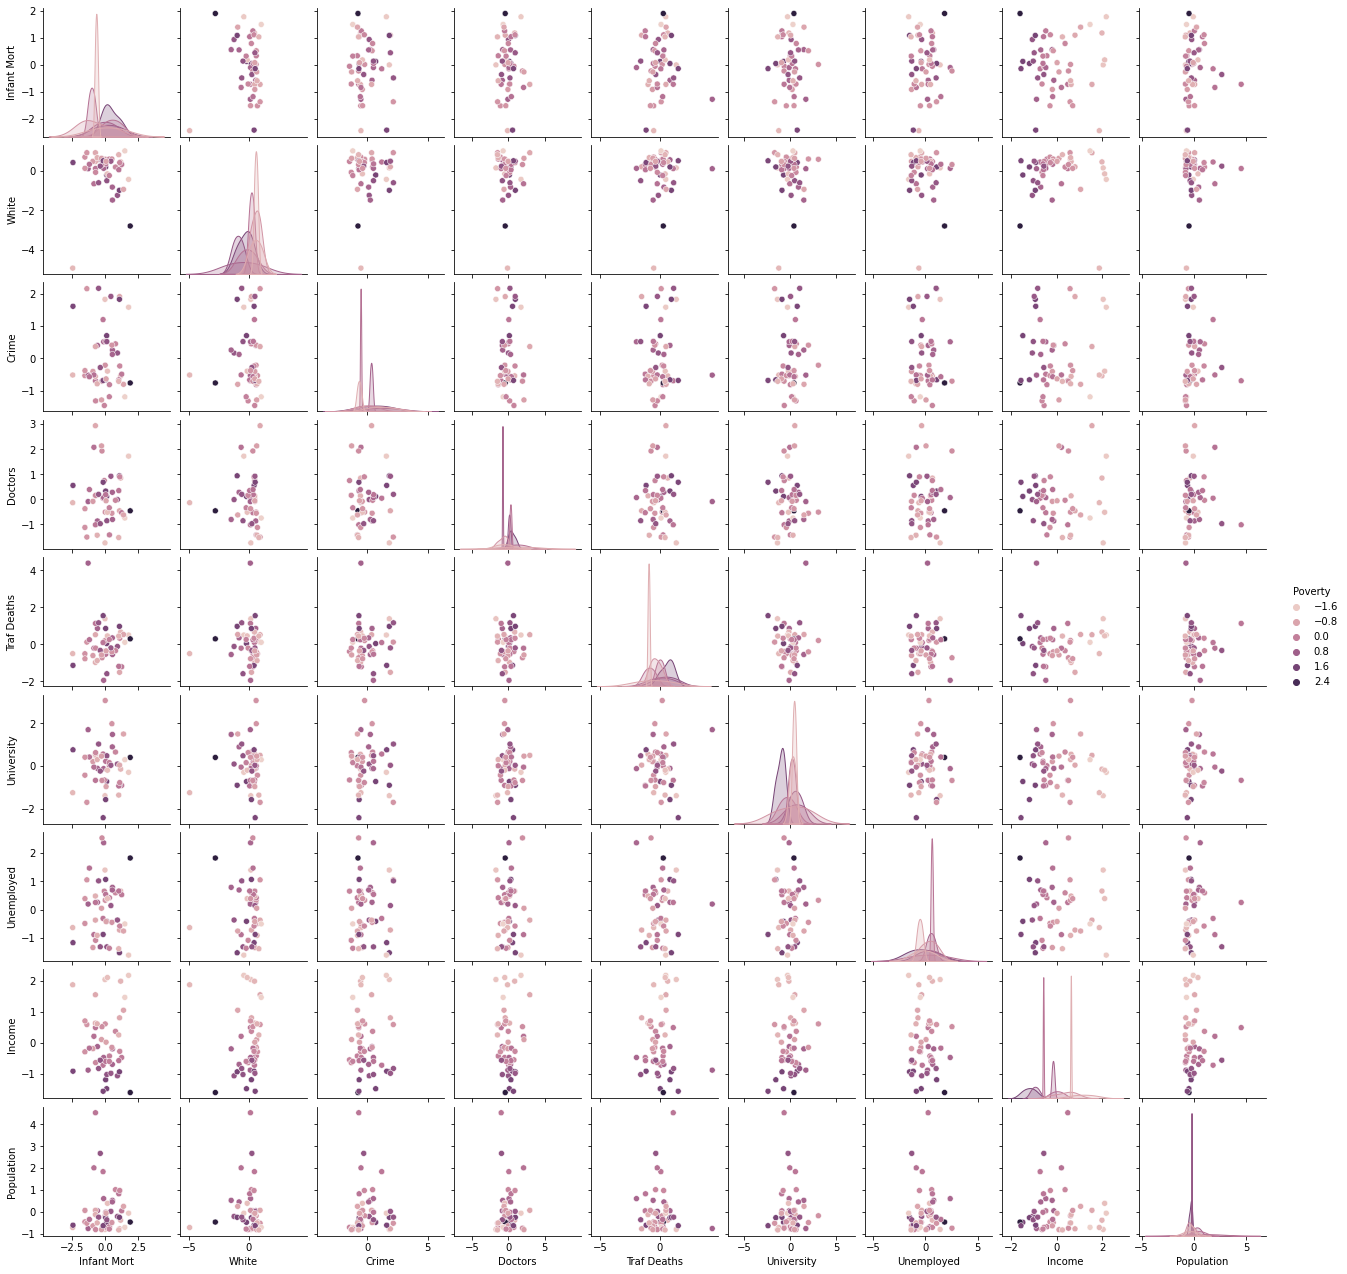

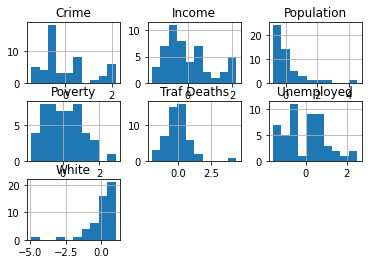

In [5]:
linear_plot = Plot.LinearRegressionResidualPlot(X_b.values, y.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

%matplotlib inline

sns.pairplot(data, hue='Poverty', height=2);

pd.concat([y,X_b],axis=1).hist()


In [206]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(scale(all_data.iloc[:,1:]))
#pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

X_pca = pd.DataFrame(pca.transform(all_data.iloc[:,1:]))

X_pca.index = all_data.index
X_pca.sort_values(by=[0],ascending=False,inplace=True)
#X_pca


[0.4300452  0.64027541 0.75615596 0.82679405 0.88494424 0.92799797
 0.96156524 0.98000444 0.99484731]


K=1 fitted in 2.8749730587005615 seconds.
K=2 fitted in 1.361396074295044 seconds.
K=3 fitted in 1.8150300979614258 seconds.
K=4 fitted in 2.121232271194458 seconds.
K=5 fitted in 2.365036964416504 seconds.
K=6 fitted in 2.576181411743164 seconds.
K=7 fitted in 2.872436046600342 seconds.
K=8 fitted in 3.131131410598755 seconds.
K=9 fitted in 3.4545376300811768 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

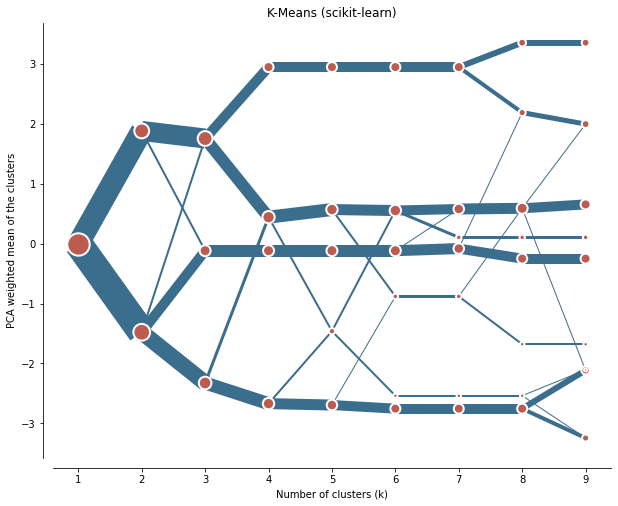

In [173]:

from sklearn.preprocessing import scale

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(scale(all_data.iloc[:,1:]))

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=True
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')


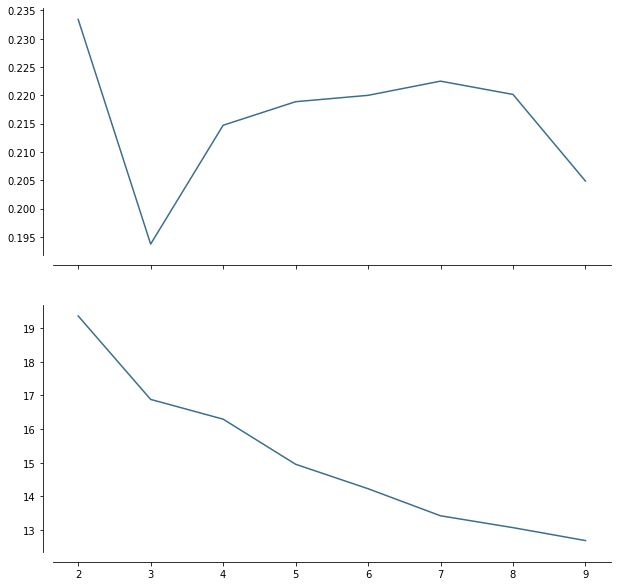

In [207]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster_pca = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]
#cluster_pca


1

T=B+W: [2.01715567e+14]
T=B+W: [2.64223561e+14]
T=B+W: [1.17984911e+14]
T=B+W: [5.60186415e+13]
T=B+W: [4.98899573e+13]
T=B+W: [3.02457708e+13]
T=B+W: [1.07907614e+13]
T=B+W: [7.7806865e+12]


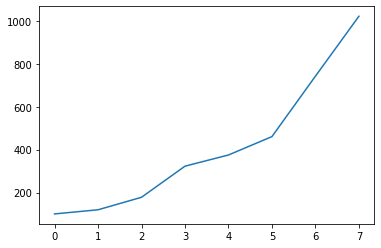

In [150]:
from sklearn.cluster import KMeans

Ratios = []
kmeans = []

for i in range(2,10): 
    #model = kmeans(X_pca, centers=i, nstart=10)
    km = KMeans(n_clusters=i, random_state=0).fit(X_pca)
    
    km.labels_
    Wss=0
    Bss=0

    for i in range(1,km.n_clusters):
        group = X_pca[km.labels_==i]
        groupmean = group.iloc[:,0].mean()
        groupss = sum((group.iloc[:,0]-groupmean)**2)
        #print(group)
        #print("  groupmean:",groupmean)
        #print("  groupss:",groupss)
        Wss+= groupss
        Bss+= ((groupmean - km.cluster_centers_[i])**2)*len(group)    
        #print(i)
    #print("Wss:",Wss)
    #print("Bss:",Bss)
    print("T=B+W:",Bss+Wss)

    TSS = Wss+Bss
    
    #Ratios.append(Bss/TSS)
    Ratios.append(sklearn.metrics.calinski_harabasz_score(X_pca, km.labels_))
    kmeans.append(km)
    
plt.plot(Ratios)



          Poverty  Infant Mort      White   Crime     Doctors  Traf Deaths  \
labels                                                                       
0       10.735714     6.142857  83.296429  336.75  288.439286     1.182857   
1       15.272727     7.704545  80.263636  497.50  224.431818     1.686364   

        University  Unemployed        Income    Population  count  
labels                                                             
0        29.882143    4.921429  57034.392857  5.640864e+06     28  
1        23.195455    5.713636  45558.727273  6.493796e+06     22  
               Poverty  Infant Mort  White  Crime  Doctors  Traf Deaths  \
States                                                                    
Alaska             8.4          6.9   70.6    661    228.5         1.63   
California        13.3          5.0   76.6    523    268.7         1.21   
Colorado          11.4          5.7   89.7    348    259.7         1.14   
Connecticut        9.3          6.2   84

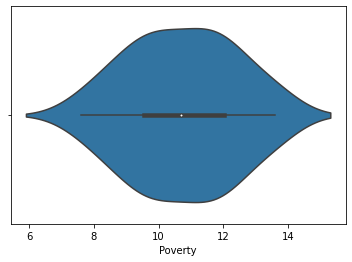

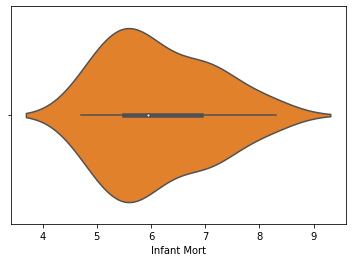

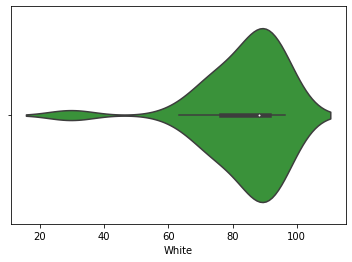

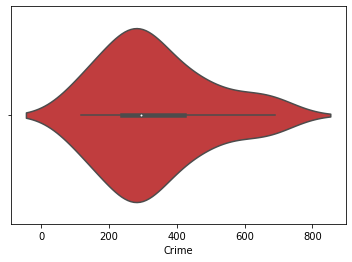

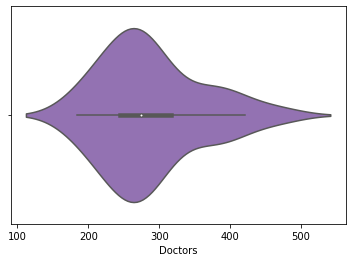

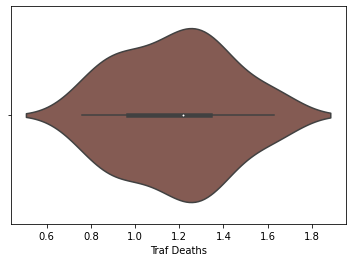

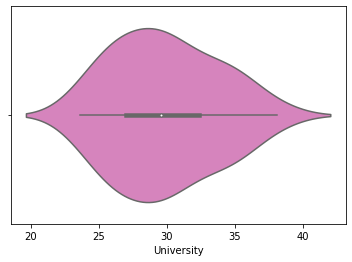

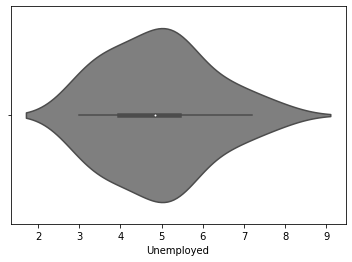

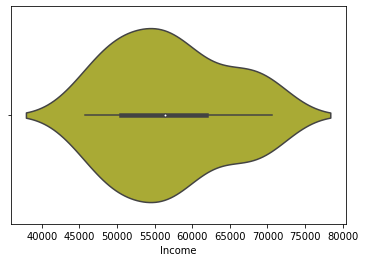

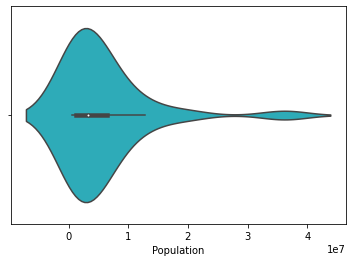

                Poverty  Infant Mort  White  Crime  Doctors  Traf Deaths  \
States                                                                     
Alabama            15.7          9.0   71.0    448    218.2         1.81   
Arizona            14.7          6.4   86.5    483    209.7         1.69   
Arkansas           17.3          8.5   80.8    529    203.4         1.96   
Florida            13.2          7.3   79.8    723    247.9         1.56   
Georgia            14.7          8.1   65.4    493    217.4         1.46   
Idaho              12.6          6.8   94.6    239    168.8         1.60   
Indiana            13.1          8.0   88.0    334    216.9         1.26   
Kentucky           17.3          7.5   89.9    295    232.3         1.80   
Louisiana          17.3          9.9   64.8    730    262.7         2.17   
Michigan           14.4          7.4   81.2    536    250.2         1.04   
Mississippi        21.2         10.6   60.6    291    177.9         2.04   
Missouri    

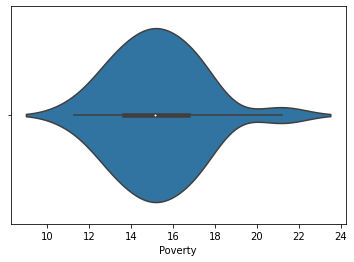

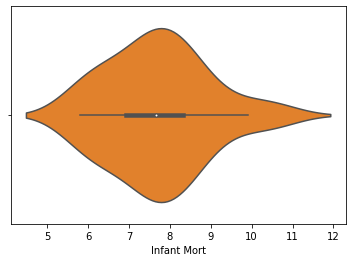

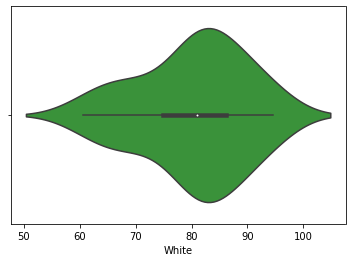

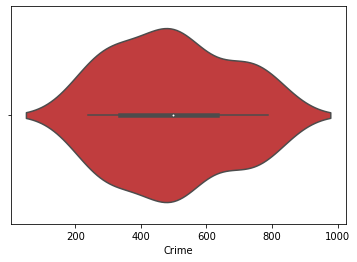

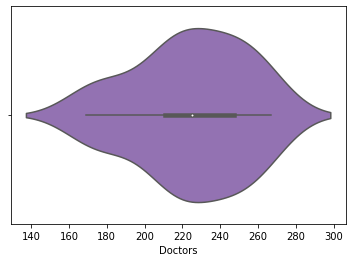

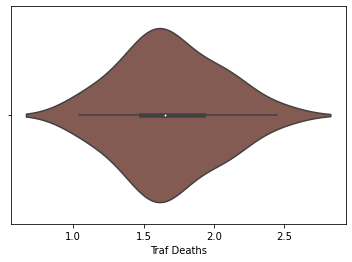

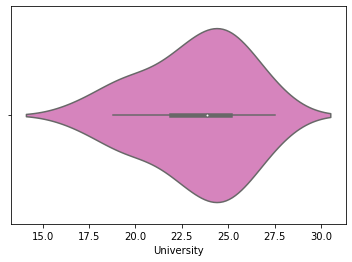

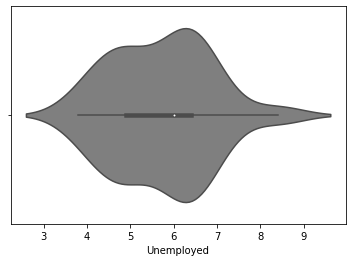

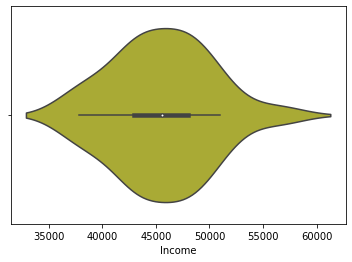

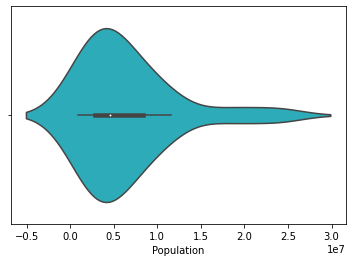

In [205]:
from itertools import cycle

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

all_data2 = all_data.iloc[:,1:]

cluster_pca.index = all_data2.index
all_data2['labels'] = pd.DataFrame(cluster_pca)

#all_data2 = all_data2.loc[X_pca.index]

summary_set2 = all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').mean()
summary_set2["count"] = pd.DataFrame(all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').count())[all_data2.columns[0]]
print(summary_set2)

%matplotlib inline 

for i in range(0,(cgram.calinski_harabasz_score()).idxmax(axis=1)):
        group = all_data2.loc[all_data2.index[cluster_pca==i]]
        #groupmean = group.iloc[:,0].mean()        
        print(group)
        for j in range(0,len(group.columns)-1):                
            #plt.subplot(1,2,1)
            fig = plt.figure(figsize=(6,4))    
            sns.violinplot(x=group[group.columns[j]],color=next(colors))
            plt.show()
        
# Violin Plots of Minimum and Maximum Temperature
    

        

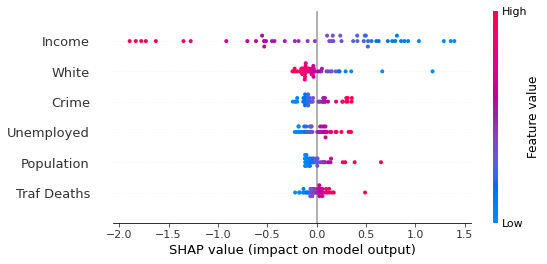

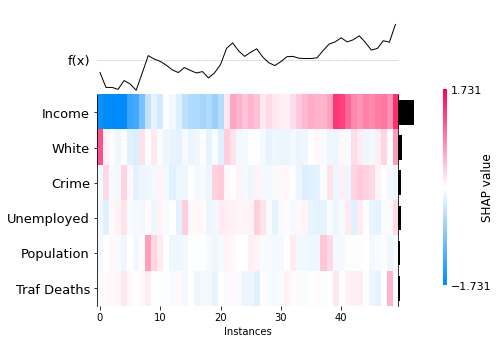

In [6]:

model = sklearn.linear_model.LinearRegression()
model.fit(X_b, y)

shap.initjs()
e = shap.explainers.Linear(model, X_b)

shap_values = e.shap_values(X_b)
shap.summary_plot(shap_values, X_b)
shap.plots.heatmap(e(X_b))

In [ ]:
# evaluate an elastic net model on the dataset
tsize = .3
train, test = train_test_split(all_data, test_size=tsize, shuffle=True)

std_ = np.std(train.iloc[:,1])
mean_ = np.mean(train.iloc[:,1])
y_train = pd.DataFrame((train.iloc[:,1]-mean_)/std_)
y_train.columns=pd.DataFrame(train.iloc[:,1]).columns
y_train.index = train.index

#StandardScaler().fit_transform(all_data.iloc[:,1])

#exclude y
trf = zca.ZCA().fit(all_data.iloc[:,2:])

X_train = pd.DataFrame(trf.transform(train.iloc[:,2:]))
X_train.columns=pd.DataFrame(train.iloc[:,2:]).columns
X_train.index = train.index

y_test = pd.DataFrame((test.iloc[:,1]-np.mean(train.iloc[:,1]))/np.std(train.iloc[:,1]))
y_test.columns=pd.DataFrame(test.iloc[:,1]).columns
y_test.index = test.index

X_test = pd.DataFrame(trf.transform(test.iloc[:,2:]))
X_test.columns=pd.DataFrame(test.iloc[:,2:]).columns
X_test.index = test.index


In [ ]:

'''
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
'''

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, verbose=0)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

# define model
model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)

# fit model
model.fit(X_train, y_train)

# define new data
#row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model.predict(X_test)
# summarize prediction
#print('Predicted: %.3f' % yhat)

In [ ]:
coef = pd.DataFrame(model.coef_).set_index(X_train.columns)
a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
a_coef

In [ ]:
print(model.score(X_train, y_train, sample_weight=None))
print(model.score(X_test, y_test, sample_weight=None))
print(model.score(X, y, sample_weight=None))
print(model.coef_)

In [ ]:
import matplotlib.pyplot as plt
predicted = pd.DataFrame(yhat*std_+mean_)
predicted.index = y_test.index
predicted.columns = y_test.columns
actual = pd.DataFrame(y_test*std_+mean_)
actual.index = y_test.index
plt.scatter(predicted, actual)

plt.show()

plt.hist(predicted-actual, bins='auto')  # arguments are passed to np.histogram

rmse = mean_squared_error(actual, predicted, squared=True)
mape = MAPE(actual, predicted)

print("rmse",rmse)
print("mape",mape)

In [ ]:
%matplotlib inline
shap.initjs()

# select a set of background examples to take an expectation over
background = np.array(data)
#[np.random.choice(X_train.shape[0],100,replace=False)]

#model = sklearn.linear_model.LinearRegression()
#model.fit(data.iloc[:,1:], data.iloc[:,0])

# explain predictions of the model on four images
e = shap.LinearExplainer(model, X_train)
#explainer = shap.KernelExplainer(model, X_train, link="logit")
print(y_test.columns)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
explainer = shap.Explainer(model, X_train)
shap.plots.heatmap(explainer(X_test))

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

pre_list = feature_importance[feature_importance["feature_importance_vals"]>.025]["col_name"].values.tolist()
pre_list.insert(0,all_data.columns[1])

In [ ]:
set_ = data[pre_list]
set_.index = all_data.iloc[:,0]
#set_ = data[["Poverty","Income"]]

In [ ]:
n=2

In [ ]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]

trf = zca.ZCA().fit(all_data.iloc[:,1:])

white_data = pd.DataFrame(trf.transform(all_data.iloc[:,1:]))
white_data.index = all_data.index
white_data.columns = all_data.iloc[:,1:].columns
white_data.index = all_data.index

eps_tries = arange(0.1, 5, 0.1)
clusters = []

for i in range(0,len(eps_tries)):
    
    db = DBSCAN(eps=eps_tries[i], min_samples=2).fit(white_data)
    labels = db.labels_
    #print (labels)
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels))
    clusters.append(clusterNum)

max_e = pd.DataFrame(clusters)[0].idxmax(axis=1)

db = DBSCAN(eps=eps_tries[max_e], min_samples=2).fit(white_data)
labels = db.labels_
print (labels)
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

white_data["clusters"] = labels
all_data['clusters'] = labels

sns.pairplot(white_data, height=2, hue="clusters");

white_data.hist()

summary_set_w = all_data[white_data['clusters']>=-1][white_data.columns].groupby('clusters').mean()
summary_set_w["count"] = pd.DataFrame(all_data[white_data['clusters']>=-1][white_data.columns].groupby('clusters').count())[white_data.columns[0]]
summary_set_w

In [ ]:
from sklearn.preprocessing import scale

data_set = scale(all_data.iloc[:,1:])
#data_set = white_data

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(data_set)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=True
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')


In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster-pca = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]

In [ ]:
cgram = Clustergram(range(1, 10), n_init=100, method="gmm")
cgram.fit(data_set)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=True
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title("Gaussian Mixture Model (scikit-learn)")

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster-gmm = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]

In [ ]:

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

k = 7

grdevices = importr('grDevices')

grdevices.png(file="kNNdistplot.png", width=512, height=512)
ro.r('''
eq <- function(values, k_) {
library(dbscan,lib.loc = "/mnt/distvol/R-4.0.5/library")
#data <- read.csv("/mnt/distvol/data.csv")
kNNdistplot(values,k=k_)
}
''')
r_eq = ro.globalenv['eq']
p=ro.conversion.rpy2py((r_eq(ro.conversion.py2rpy(set_),k)))
#p = ro.r('eq(1)')            # OUTPUTS TO FILE
grdevices.dev_off()
from IPython.display import Image
Image("kNNdistplot.png")


In [ ]:
eps_tries = arange(0.1, 5, 0.1)
clusters = []

for i in range(0,len(eps_tries)):
    
    db = DBSCAN(eps=eps_tries[i], min_samples=n).fit(set_)
    labels = db.labels_
    #print (labels)
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels))
    clusters.append(clusterNum)

max_e = pd.DataFrame(clusters)[0].idxmax(axis=1)

db = DBSCAN(eps=eps_tries[max_e], min_samples=n).fit(set_)
labels = db.labels_
print (labels)
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
set_["clusters"]=labels
all_data['clusters'] = labels


In [ ]:
summary_set = all_data[all_data['clusters']>=-1][set_.columns].groupby('clusters').mean()
summary_set["count"] = pd.DataFrame(all_data[all_data['clusters']>=-1][set_.columns].groupby('clusters').count())[set_.columns[0]]
summary_set

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

sns.set(style = "darkgrid")

fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(111, projection = '3d')

x = set_.iloc[:,1]
y = set_.iloc[:,2]
z = set_.iloc[:,3]

m = np.array([x,y,z])
scatter = ax.scatter(x,y,z, c=set_.iloc[:,0], cmap="RdYlGn", s=(set_['clusters']+2)*40, edgecolors="black")

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

#legend2 = ax.legend(*scatter.legend_elements(prop="sizes", alpha=0.6),loc="upper left", title="clusters")

legend2 = ax.legend(handles, range(0,len(labels)), loc="upper right", title="clusters")
#ax.legend()
ax.add_artist(legend2)
    
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
for i in range(len(m[0]-1)): #plot each point + it's index as text above 
    #ax.scatter(m[0,i],m[1,i],m[2,i], marker=set_.iloc[i]['clusters']+2, s=100, color='k') 
    ax.text(m[0,i],m[1,i],m[2,i],  '%s' % (str(states[i])), size=10, zorder=1,  color='k') 
   
#legend1 = ax.legend(*scatter.legend_elements(num=5),loc="upper left", title="Ranking")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Poverty")
ax.add_artist(legend1)


#kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",func=lambda s: np.sqrt(s/.3)/3)

#legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Price")

ax.legend()
ax.set_xlabel(set_.columns[1])
ax.set_ylabel(set_.columns[2])
ax.set_zlabel(set_.columns[3])
plt.show()


In [ ]:

from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

%matplotlib inline
sns.set(style='whitegrid')

#iris = sns.load_dataset(pd.concat([y,X_b],axis=1))
g = sns.pairplot(set_, hue="clusters")
g.fig.suptitle("Data", y=1.01)

In [ ]:
# Violin Plots of Minimum and Maximum Temperature
from itertools import cycle

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

%matplotlib inline 
for i in range(-1,clusterNum-1):
    print("cluster:")
    print(i)
    fig = plt.figure(figsize=(6,4))    
    for j in range(0,len(set_.columns)-1):                
        #plt.subplot(1,2,1)
        sns.violinplot(x=all_data[all_data['clusters']==i][set_.columns[j]],color=next(colors))
        plt.show()
